In [1]:
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

## Image Augmentation

In [2]:
train_url = "C:\\Users\\ADMIN\\Desktop\\WasteClassification\\DATASET\\TRAIN"
test_url = "C:\\Users\\ADMIN\\Desktop\\WasteClassification\\DATASET\\TEST"

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   validation_split=0.1)

val_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 64
img_size = (128, 128)

train_set = train_datagen.flow_from_directory(train_url, 
                                              class_mode='binary',
                                              batch_size = batch_size,
                                              target_size=img_size,
                                              subset='training')

val_set = train_datagen.flow_from_directory(train_url, 
                                           class_mode = 'binary',
                                           batch_size = batch_size,
                                           target_size=img_size,
                                           subset = 'validation')

test_set = val_datagen.flow_from_directory(test_url, 
                                           class_mode = 'binary',
                                           batch_size = batch_size,
                                           shuffle=False,
                                           target_size=img_size)

Found 20309 images belonging to 2 classes.
Found 2255 images belonging to 2 classes.
Found 2514 images belonging to 2 classes.


## Base Model

In [3]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128,128,3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        3

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model', save_best_only=True)

hist = model1.fit(train_set, validation_data=val_set, epochs=20, callbacks=[early_stopping, checkpoint])

## Transfer Learning with MobileNetV2

In [4]:
baseModel = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), weights='imagenet',
                                           include_top=False, classes=1)

for layers in baseModel.layers:
    layers.trainable=False

In [5]:
model = tf.keras.models.Sequential([
    baseModel,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=50
callbacks = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_3 (Dropout)         (None, 20480)             0         
                                                                 
 dense_3 (Dense)             (None, 16)                327696    
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                      

In [6]:
history = model.fit(train_set, validation_data=val_set, epochs=epochs, callbacks=[callbacks])

Epoch 1/50
318/318 [==============================] - 276s 859ms/step - loss: 0.3556 - accuracy: 0.8528 - val_loss: 0.2449 - val_accuracy: 0.9069
Epoch 2/50
318/318 [==============================] - 236s 744ms/step - loss: 0.2918 - accuracy: 0.8792 - val_loss: 0.2037 - val_accuracy: 0.9237
Epoch 3/50
318/318 [==============================] - 218s 685ms/step - loss: 0.2684 - accuracy: 0.8894 - val_loss: 0.1992 - val_accuracy: 0.9255
Epoch 4/50
318/318 [==============================] - 180s 564ms/step - loss: 0.2524 - accuracy: 0.8988 - val_loss: 0.1949 - val_accuracy: 0.9242
Epoch 5/50
318/318 [==============================] - 181s 569ms/step - loss: 0.2433 - accuracy: 0.9002 - val_loss: 0.1932 - val_accuracy: 0.9233
Epoch 6/50
318/318 [==============================] - 190s 597ms/step - loss: 0.2381 - accuracy: 0.9049 - val_loss: 0.1828 - val_accuracy: 0.9282
Epoch 7/50
318/318 [==============================] - 218s 686ms/step - loss: 0.2316 - accuracy: 0.9081 - val_loss: 0.1791 -

#### Save model

In [7]:
model.save("waste_classifier")

INFO:tensorflow:Assets written to: waste_classifier\assets


INFO:tensorflow:Assets written to: waste_classifier\assets


#### Training process evaluating

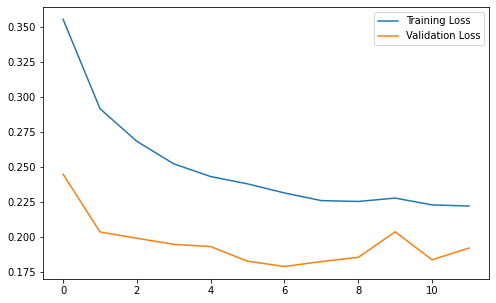

In [8]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

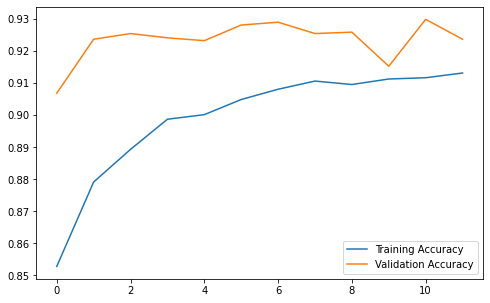

In [9]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])

In [10]:
train_set = val_datagen.flow_from_directory(train_url, 
                                           class_mode = 'binary',
                                           batch_size = batch_size,
                                           shuffle=False,
                                           target_size=img_size)

Found 22564 images belonging to 2 classes.


In [11]:
model.evaluate(train_set)
model.evaluate(test_set)

40/40 [==============================] - 29s 736ms/step - loss: 0.2433 - accuracy: 0.9037


[0.24328605830669403, 0.9037390351295471]

#### Determining Threshold 

In [12]:
def evaluate(y, y_pred, p=0.5):
    plt.figure(figsize=(10,6))
    sns.heatmap(confusion_matrix(y, y_pred >= p), annot=True)
    print(classification_report(y, y_pred >= p, digits=5))

def plot_roc_auc(y, y_pred):
    fpr, tpr, threshold = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    
    #create ROC curve
    plt.figure(figsize=(10,6))
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))
    return threshold[ix]

40/40 [==============================] - 14s 341ms/step


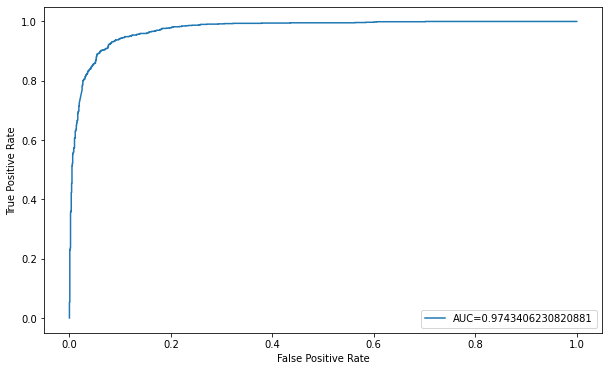

Best Threshold=0.263139, G-Mean=0.924


In [18]:
y_pred = model.predict(test_set)
THRESHOLD = plot_roc_auc(test_set.classes, y_pred)

## Final Evaluation Result

              precision    recall  f1-score   support

           0    0.94412   0.91649   0.93010      1401
           1    0.89861   0.93172   0.91487      1113

    accuracy                        0.92323      2514
   macro avg    0.92137   0.92410   0.92248      2514
weighted avg    0.92397   0.92323   0.92335      2514



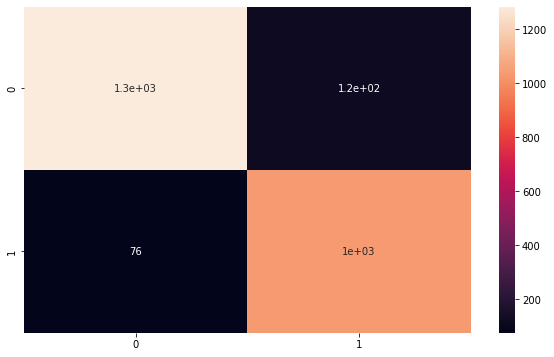

In [19]:
evaluate(test_set.classes, y_pred, p=THRESHOLD)

In [20]:
def test():
    batch = np.random.randint(0, len(test_set)-1)
    data = 0
    img = np.random.randint(0, len(test_set[batch][data])-1)
    IMAG = test_set[batch][data][img]

    plt.imshow(IMAG)
    plt.show()
    
    pred = model.predict(IMAG.reshape(1,128,128,3))
    pred_class = 'R' if pred >= THRESHOLD else 'O'
    proba = pred if pred >= THRESHOLD else 1-pred
    print(f'model predict: {pred_class} with probability {proba[0][0]}')

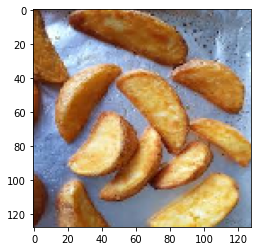

1/1 [==============================] - 0s 34ms/step
model predict: O with probability 0.9980467557907104


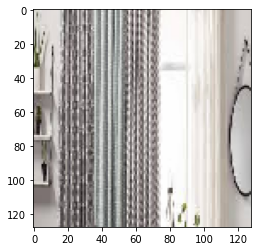

1/1 [==============================] - 0s 46ms/step
model predict: R with probability 0.9198171496391296


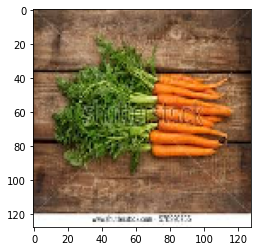

1/1 [==============================] - 0s 35ms/step
model predict: O with probability 0.9684274792671204


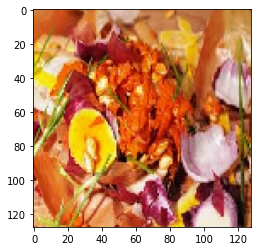

1/1 [==============================] - 0s 32ms/step
model predict: O with probability 0.9971467852592468


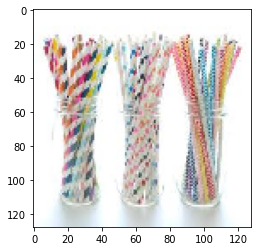

1/1 [==============================] - 0s 33ms/step
model predict: R with probability 0.8285009860992432


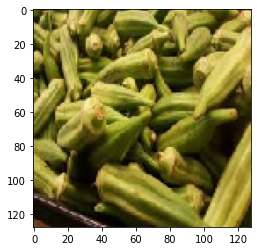

1/1 [==============================] - 0s 41ms/step
model predict: O with probability 0.9709943532943726


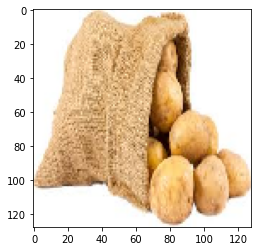

1/1 [==============================] - 0s 32ms/step
model predict: O with probability 0.9988884329795837


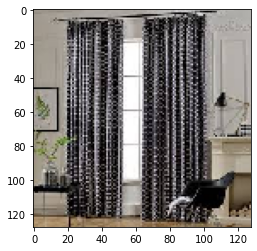

1/1 [==============================] - 0s 33ms/step
model predict: R with probability 0.8435583710670471


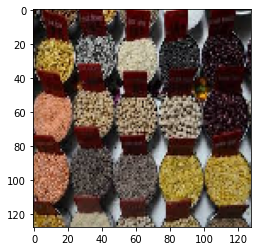

1/1 [==============================] - 0s 46ms/step
model predict: O with probability 0.8845034837722778


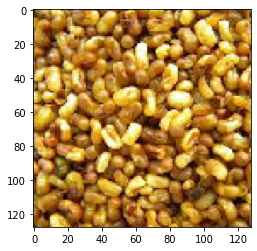

1/1 [==============================] - 0s 33ms/step
model predict: O with probability 0.9998428225517273


In [21]:
for i in range(10):
    test()